<a href="https://colab.research.google.com/github/samanehPahlavani/MscFraudDetection/blob/main/Model5_SVM(SupportVectorMachine).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import sys
try:
  import google.colab
  !{sys.executable} -m pip -q -q install pandas>=0.24.2
  !{sys.executable} -m pip -q -q install matplotlib>=3.0.3
  !{sys.executable} -m pip -q -q install seaborn>=0.9.1
  !{sys.executable} -m pip -q -q install numpy>=1.18.5
  !{sys.executable} -m pip -q -q install scikit-learn>=0.22.2
  !{sys.executable} -m pip -q -q install pycm>=2.2
except:
  pass

In [7]:
# Import necessary libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

In [8]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from pycm import ConfusionMatrix, Compare
RANDOM_STATE = 23
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, precision_score, recall_score


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
def LoadData():
  warnings.filterwarnings('ignore')
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  df = pd.read_csv(os.path.join("/content/drive/MyDrive/EtherFirstDataSet/", "3.csv"))
  return df

In [11]:
def preprocess(df):
  RANDOM_STATE = 23
  positive_sample = df[df["Flag"] == 1]
  negative_sample = df[df["Flag"] == 0].sample(len(positive_sample), random_state = RANDOM_STATE)
  data = pd.concat([negative_sample, positive_sample], axis = 0)
  y = data["Flag"]
  X = data.iloc[:,2:]

  for col in X.columns:
      X[col] = X[col].fillna(X[col].mean())
  return X,y

In [12]:
df= LoadData()
X,y=preprocess(df)

In [13]:
FOLD_NUMBER = 10
METRIC_LIST = ["Accuracy", "F1", "Kappa", "Precision", "Recall"]

In [14]:
svm_model = SVC(kernel='linear', random_state=42)
svm = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)
cm_metric_list = []
svm_cm_worst = None
svm_cm_best = None
svm_cm_list = []
for train_index, test_index in svm.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test =  scaler.transform(X_test)
    svm_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector = y_test.values, predict_vector = svm_model.predict(X_test))
    cm_metric_list.append({"Accuracy":cm.Overall_ACC, "F1": cm.F1[1], "Kappa": cm.Kappa, "Precision":cm.PPV[1]
                        , "Recall": cm.TPR[1]})
    cm.relabel({1: "Fraud", 0:"Non-Fraud"})
    svm_cm_list.append(cm)
    if svm_cm_worst is None:
        svm_cm_worst = cm
    else:
        if cm.Overall_ACC < svm_cm_worst.Overall_ACC:
            svm_cm_worst = cm

    if svm_cm_best is None:
        svm_cm_best = cm
    else:
        if cm.Overall_ACC > svm_cm_best.Overall_ACC:
            svm_cm_best = cm


Model Name: svm Classifier

10-Fold Metrics: 

Accuracy : 0.64

F1 : 0.73

Kappa : 0.29

Precision : 0.59

Recall : 0.97



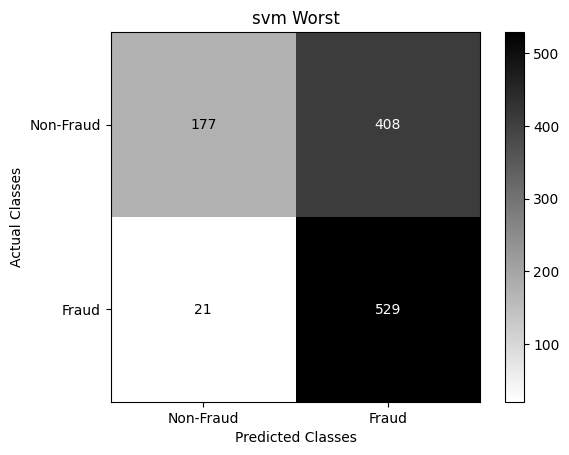

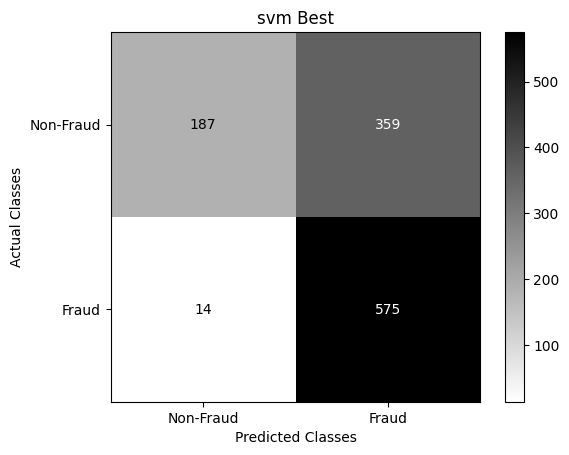

In [15]:

print("Model Name: svm Classifier\n")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
svm_cm_worst.plot(title="svm Worst", number_label=True)
svm_cm_best.plot(title="svm Best", number_label=True)
plt.show()
